In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import bemcs


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define geometry of single element model

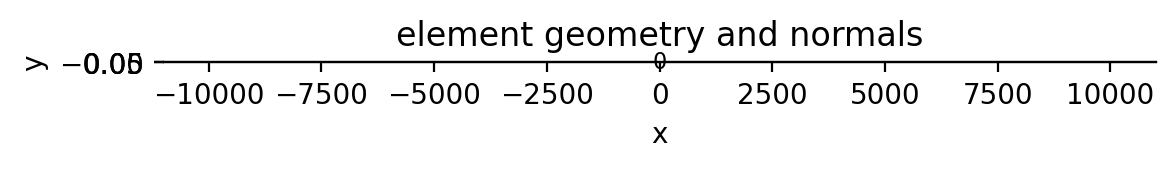

In [3]:
# List of elements for forward model
n_els = 1
mu = 3e10
nu = 0.25
L = 10000
x1, y1, x2, y2 = bemcs.discretized_line(-L, 0, L, 0, n_els)
els = bemcs.initialize_els()
els.x1 = np.copy(x1)
els.y1 = np.copy(y1)
els.x2 = np.copy(x2)
els.y2 = np.copy(y2)
bemcs.standardize_els_geometry(els)
bemcs.plot_els_geometry(els)

# Observation coordinates

In [4]:
n_pts = 100
width = 20000
x_obs = np.linspace(-width, width, n_pts)
y_obs = np.linspace(-width, width, n_pts)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# Single constant slip element

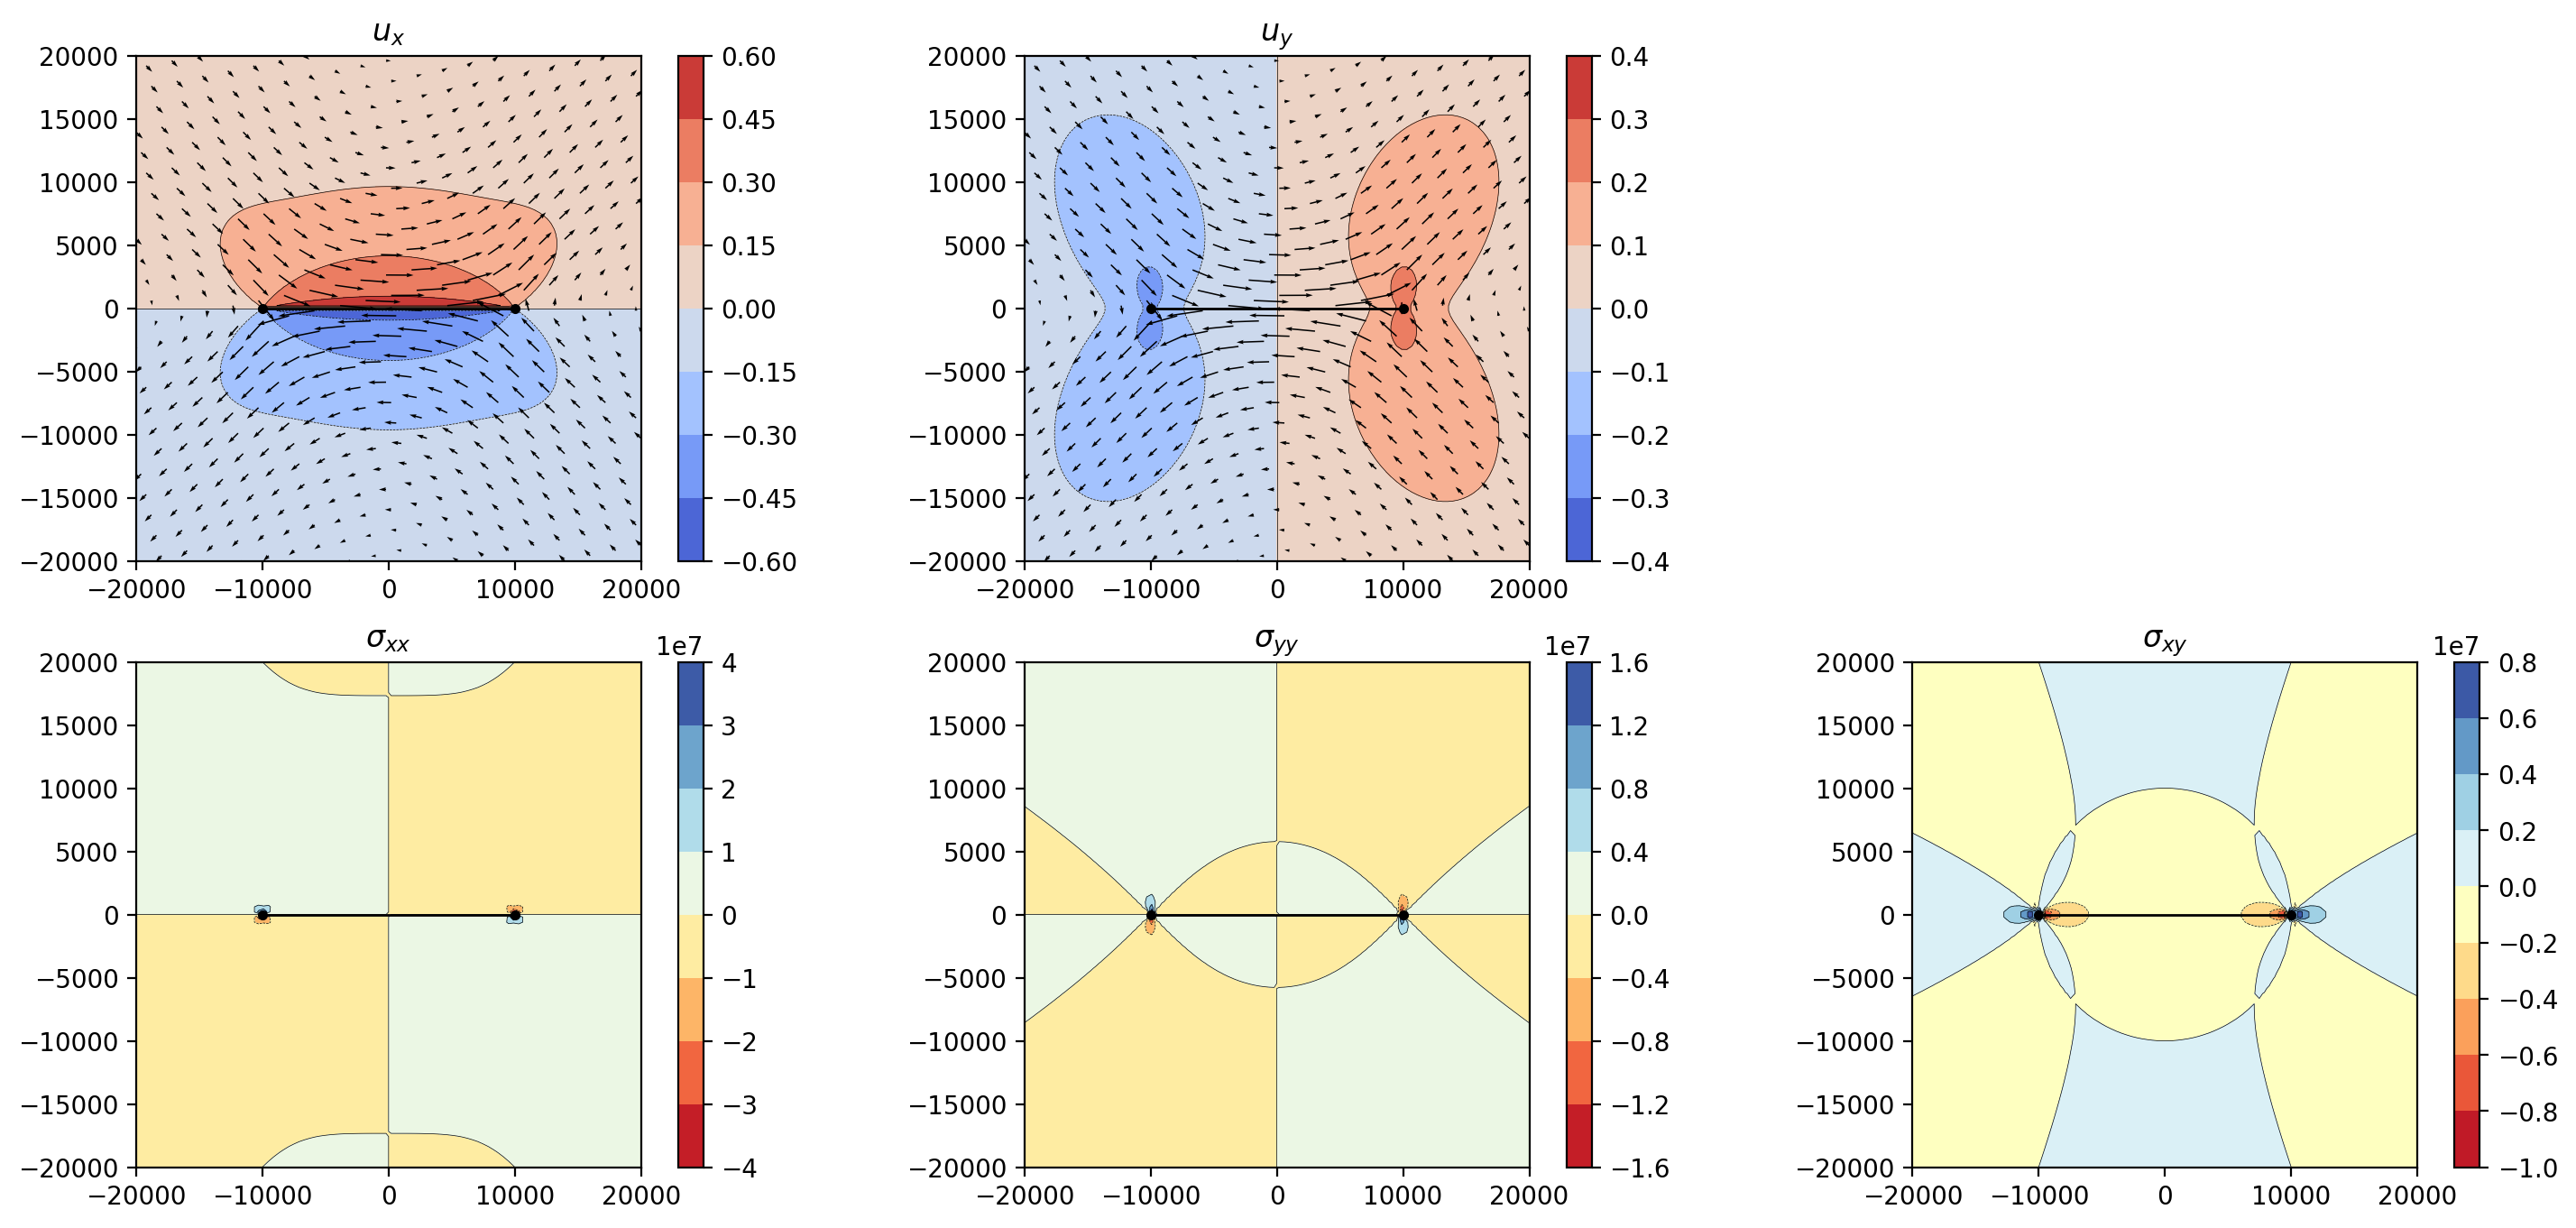

In [5]:
strike_slip_constant = 1
tensile_slip_constant = 0

(
    displacement_constant,
    stress_constant,
) = bemcs.displacements_stresses_constant_no_rotation(
    x_obs,
    y_obs,
    els.half_lengths[0],
    mu,
    nu,
    strike_slip_constant,
    tensile_slip_constant,
    els.x_centers[0],
    els.y_centers[0],
)

ux = displacement_constant[0, :]
uy = displacement_constant[1, :]
sxx = stress_constant[0, :]
syy = stress_constant[1, :]
sxy = stress_constant[2, :]

bemcs.plot_displacements_stresses_els(
    els, n_pts, ux, uy, sxx, syy, sxy, x_obs, y_obs, n_skip_plot=21
)

# Single quadratic slip element

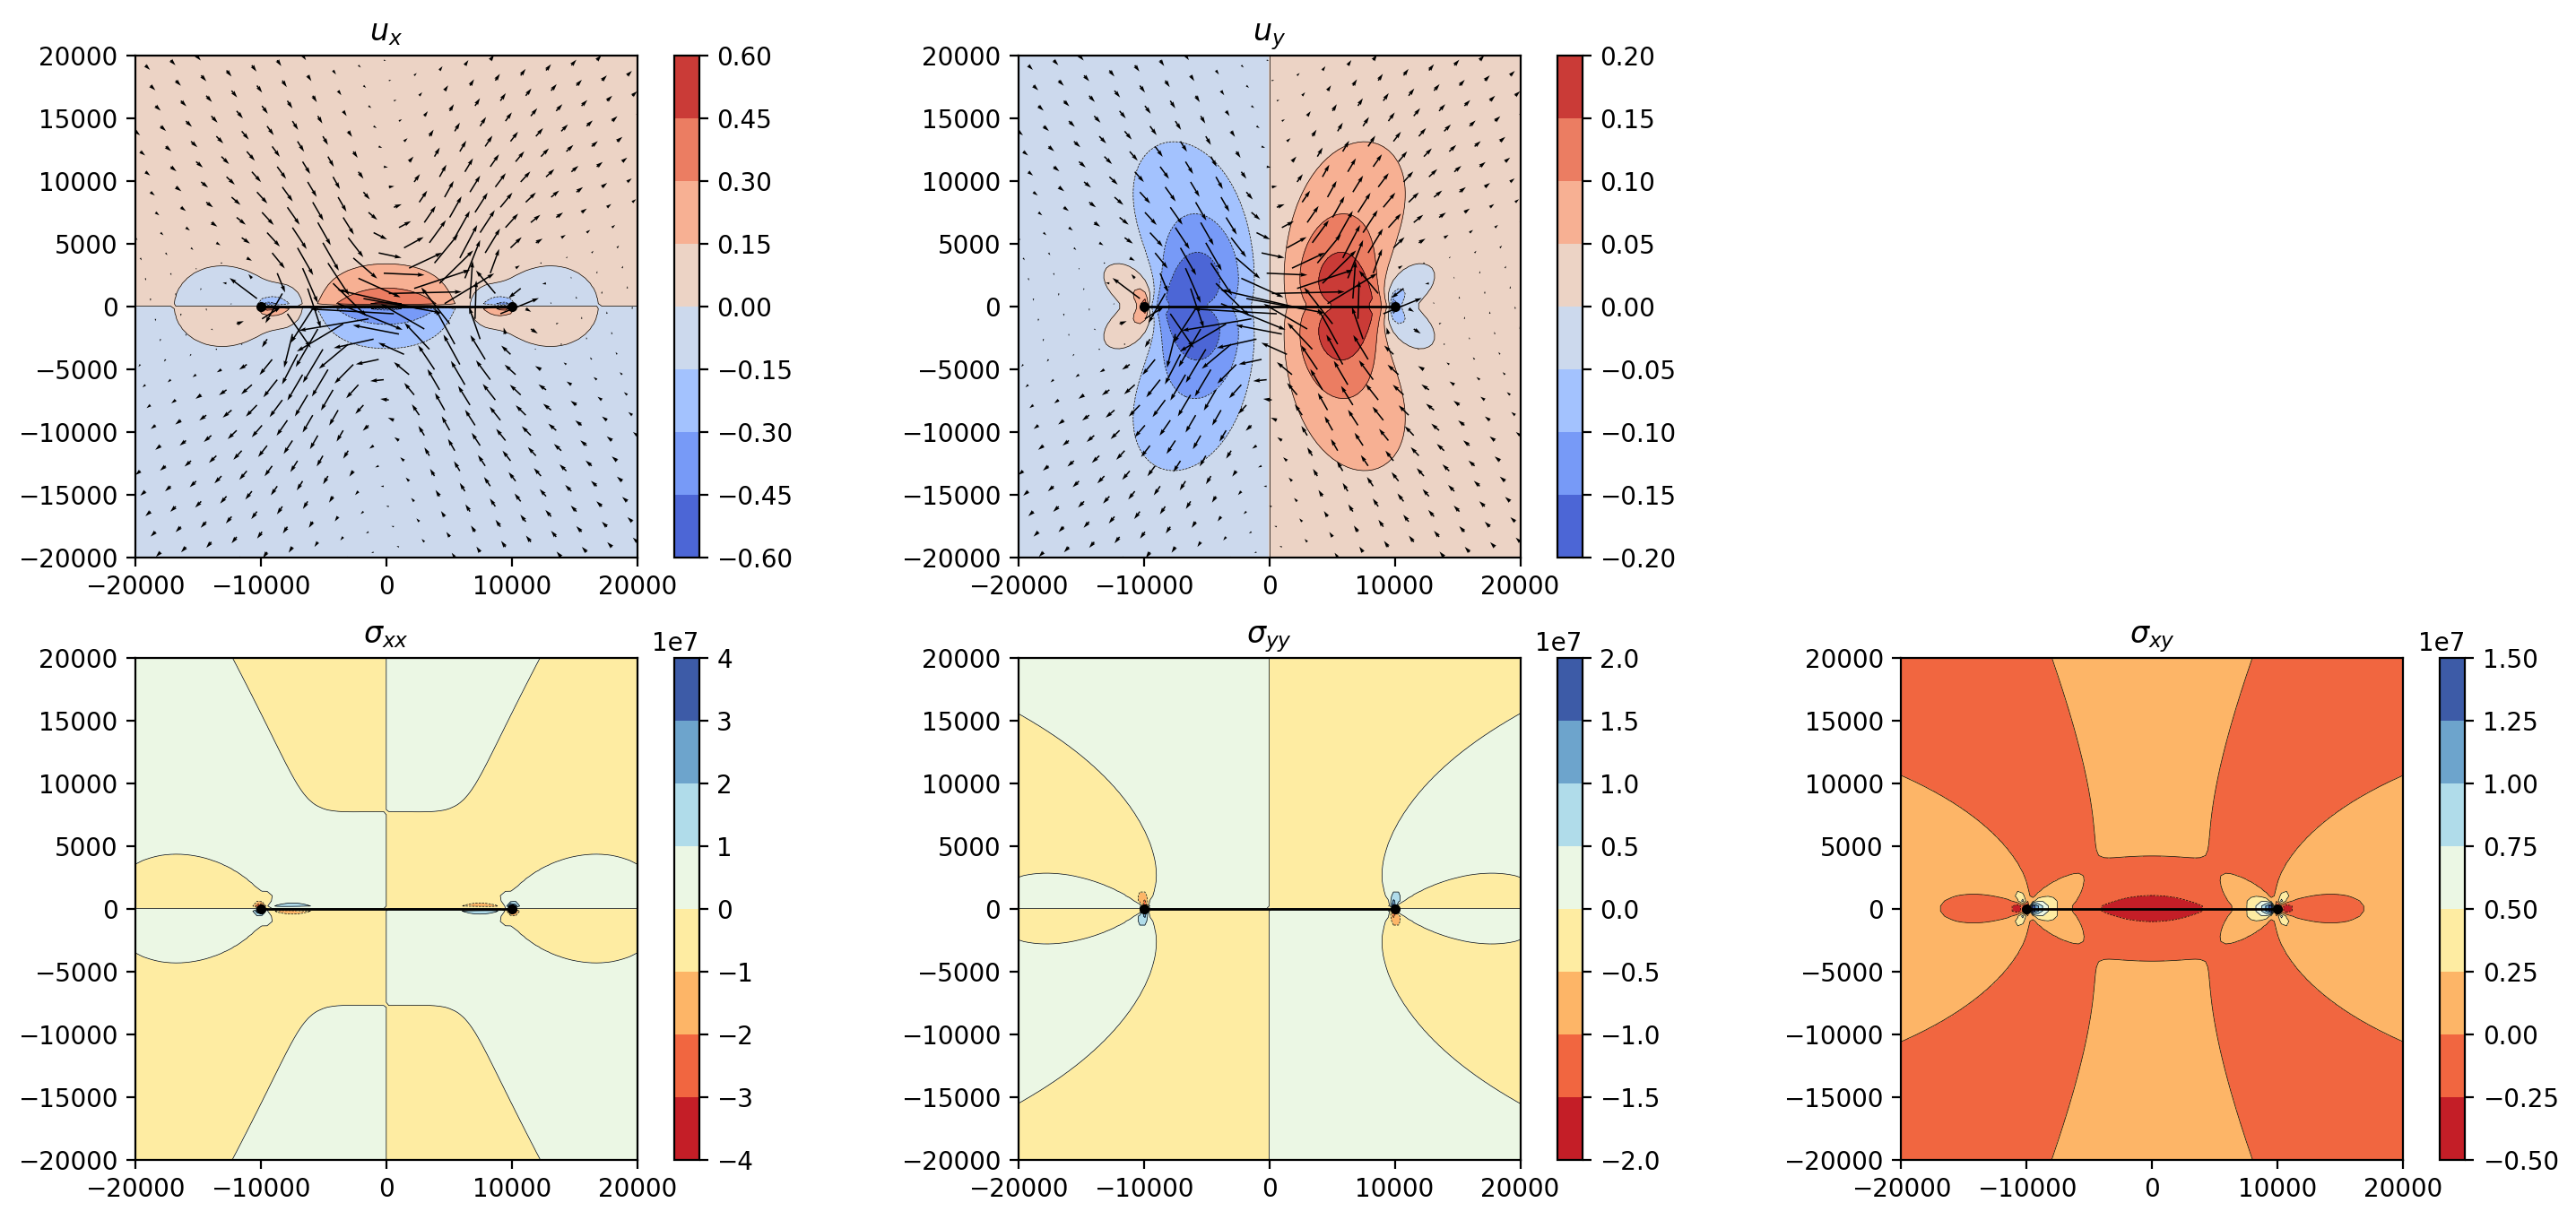

In [6]:
strike_slip_quadratic = [0.0, 1.0, 0.0]
tensile_slip_quadratic = [0.0, 0.0, 0.0]

(
    displacement_quadratic,
    stress_quadratic,
) = bemcs.displacements_stresses_quadratic_no_rotation(
    x_obs,
    y_obs,
    els.half_lengths[0],
    mu,
    nu,
    strike_slip_quadratic,
    tensile_slip_quadratic,
    els.x_centers[0],
    els.y_centers[0],
)

ux = displacement_quadratic[0, :]
uy = displacement_quadratic[1, :]
sxx = stress_quadratic[0, :]
syy = stress_quadratic[1, :]
sxy = stress_quadratic[2, :]

bemcs.plot_displacements_stresses_els(
    els, n_pts, ux, uy, sxx, syy, sxy, x_obs, y_obs, n_skip_plot=21
)

# Making quadratic elements have linear slip
Quadratic slip elements actually have solutions composed of quadratic functions specified at three distinct locations on each element.  I'm not sure why I did this but it's pretty flexible this way.  The task is to relate the coefficients that modulate the shape of each of these three quadratic functions to create the physical slip profile that we want. Exerpting from the `Bem2d.jl` paper:

An additional and necessary step is to relate the shape function coefficients $c_i$ to the  displacement discontinuity/fault slip $\Delta u_i$ at each node. We can do this by solving for the \remove{the} coefficients $c_{i}$ that multiply each shape function $\phi_{i}$ to give the variation in slip. All we need to do is solve the linear system with slip sampled at the locations of the three element nodes, $u(x_{1}),u(x_{2}),u(x_{3})$,

$
\begin{equation}
    \begin{bmatrix}
        c_{1}\\
        c_{2}\\
        c_{3}
    \end{bmatrix}
    =
    \begin{bmatrix}
        \phi_{1}(x_{1},a) & \phi_{2}(x_{1},a) & \phi_{3}(x_{1},a)\\
        \phi_{1}(x_{2},a) & \phi_{2}(x_{2},a) & \phi_{3}(x_{2},a)\\
        \phi_{1}(x_{3},a) & \phi_{2}(x_{3},a) & \phi_{3}(x_{3},a)
    \end{bmatrix}^{-1}\begin{bmatrix}
        \Delta u(x_{1})\\
        \Delta u(x_{2})\\
        \Delta u(x_{3})
    \end{bmatrix}
\end{equation}
$

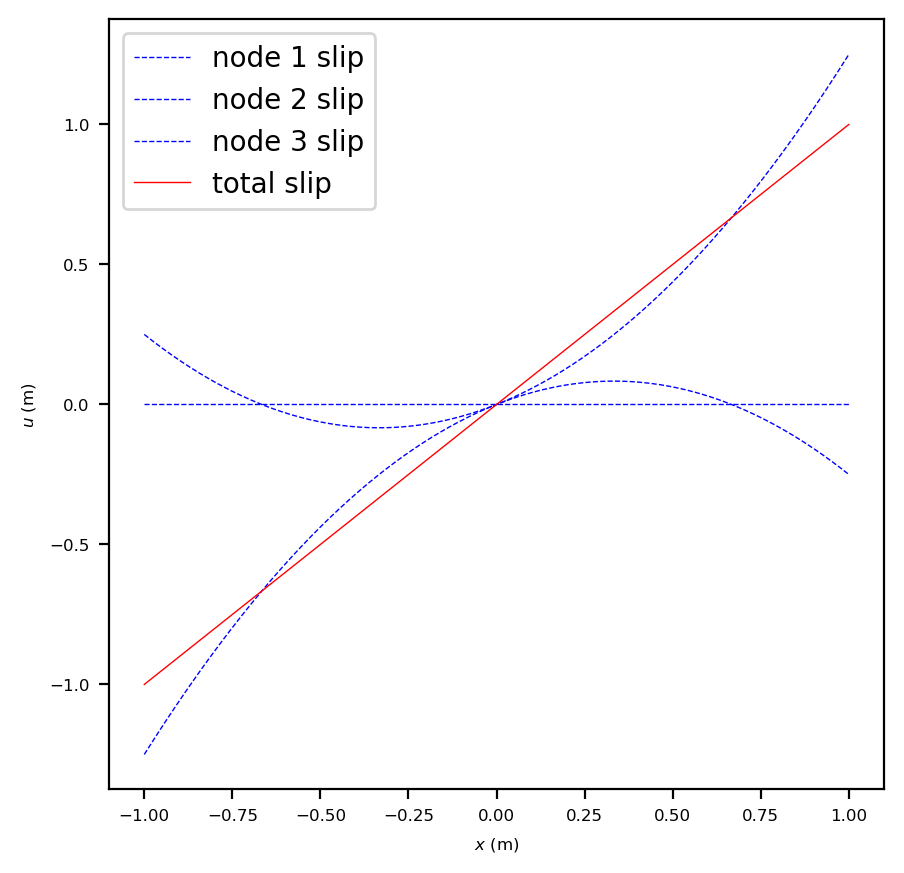

In [7]:
linewidth = 0.5
fontsize = 6
n = 1000
a = 1
x = np.linspace(-a, a, n)

# phi shape functions and coefficients
phi1 = (x / a) * (9 * (x / a) / 8 - 3 / 4)
phi2 = (1 - 3 * (x / a) / 2) * (1 + 3 * (x / a) / 2)
phi3 = (x / a) * (9 * (x / a) / 8 + 3 / 4)
xvals = np.array([-1.0, 0.0, 1.0])
yvals = np.array([-1.0, 0.0, 1.0])  # linear slip

coef = bemcs.phicoef(xvals, yvals, a)

plt.close("all")
plt.figure(figsize=(5, 5))
plt.plot(
    x, coef[0] * phi1, "--", color="blue", linewidth=linewidth, label="node 1 slip"
)
plt.plot(
    x, coef[1] * phi2, "--", color="blue", linewidth=linewidth, label="node 2 slip"
)
plt.plot(
    x, coef[2] * phi3, "--", color="blue", linewidth=linewidth, label="node 3 slip"
)
plt.plot(
    x,
    coef[0] * phi1 + coef[1] * phi2 + coef[2] * phi3,
    "-r",
    linewidth=linewidth,
    label="total slip",
)
plt.legend()
plt.xlabel("$x$ (m)", fontsize=fontsize)
plt.ylabel("$u$ (m)", fontsize=fontsize)
plt.gca().tick_params(labelsize=fontsize)
plt.show()


# quadratic_nodes_to_slip_figure()

# A single linear element as a reduced case of the quadratic element

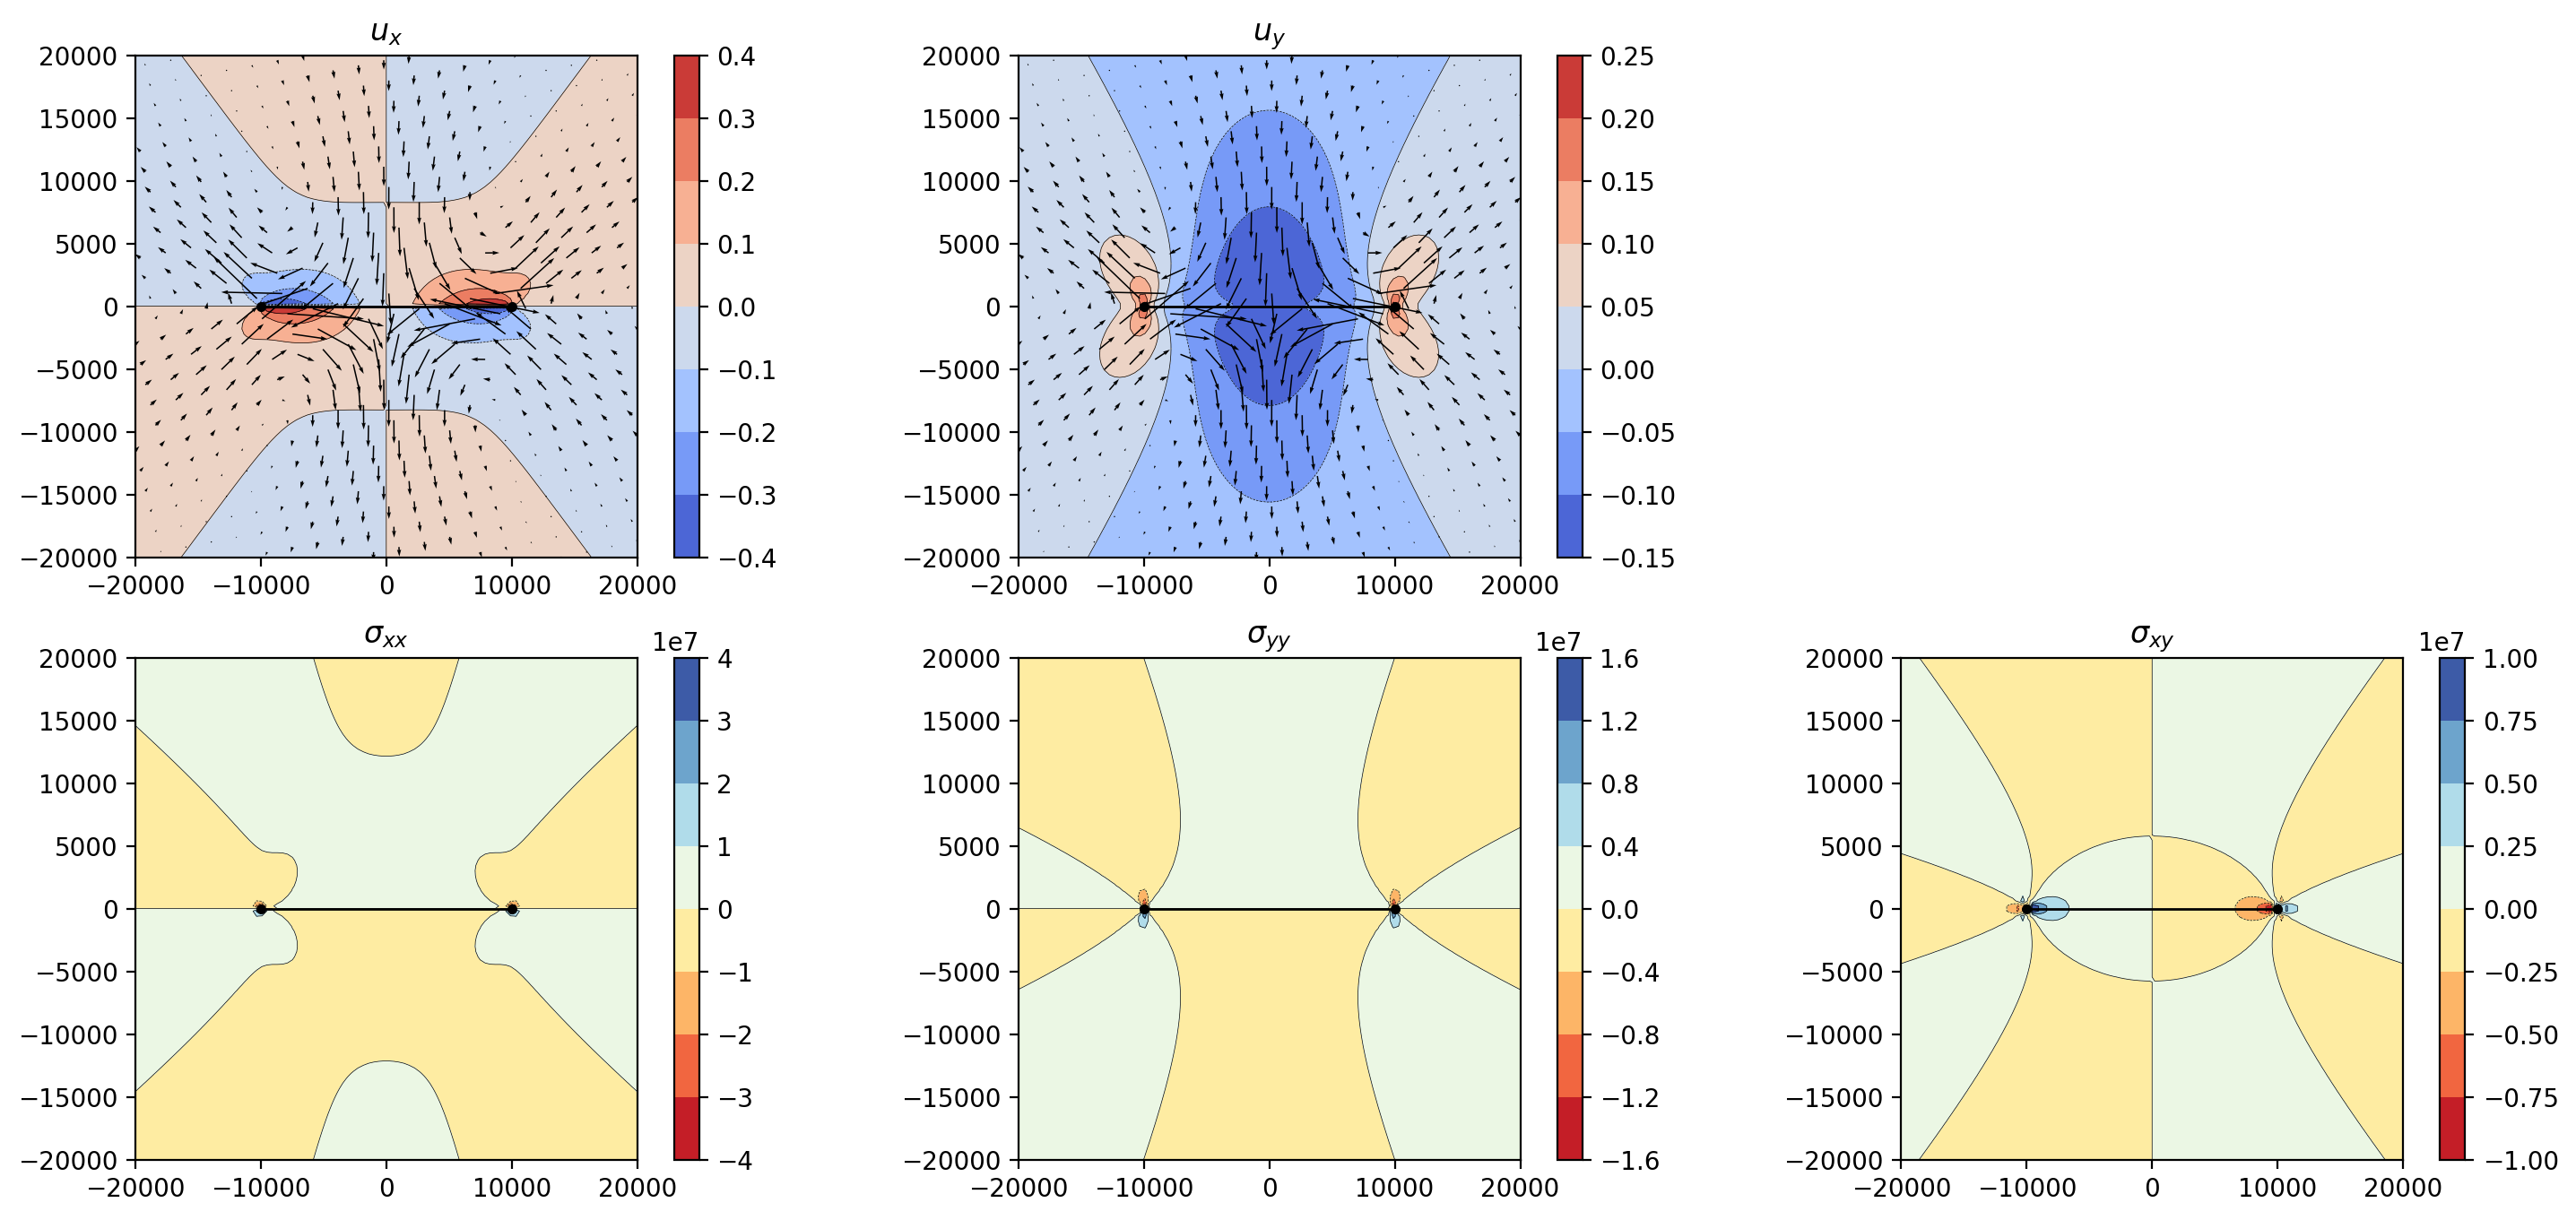

In [8]:
# Element half-width (packaged in element dictionary)
a = 1.0

# Specify endpoint displacments
node_coordinates = np.array([-1.0, 0.0, 1.0])
end_displacement_1 = -1.0
end_displacement_2 = 1.0

quadratic_coefficients = bemcs.get_quadratic_coefficients_for_linear_slip(
    a, node_coordinates, end_displacement_1, end_displacement_2
)

strike_slip_quadratic = np.copy(quadratic_coefficients)
tensile_slip_quadratic = [0.0, 0.0, 0.0]

(
    displacement_quadratic,
    stress_quadratic,
) = bemcs.displacements_stresses_quadratic_no_rotation(
    x_obs,
    y_obs,
    els.half_lengths[0],
    mu,
    nu,
    strike_slip_quadratic,
    tensile_slip_quadratic,
    els.x_centers[0],
    els.y_centers[0],
)

ux = displacement_quadratic[0, :]
uy = displacement_quadratic[1, :]
sxx = stress_quadratic[0, :]
syy = stress_quadratic[1, :]
sxy = stress_quadratic[2, :]

bemcs.plot_displacements_stresses_els(
    els, n_pts, ux, uy, sxx, syy, sxy, x_obs, y_obs, n_skip_plot=21
)